In [1]:
import os
import re
import csv
import joblib
import datetime
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from scipy.stats import randint, uniform

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
industrial_df=pd.read_csv("industrial_data.csv")
industrial_df.head()

,ID,Month Year,Project Name,Street Name,Planning Area,Type of Sale,Price,$psm,Area,Tenure,Contract Date,Property Type,Type Of Area,Floor Level,Region,Postal Sector,Postal District,Unnamed: 17,Unnamed: 18
0,41711.0,2021-01,WAVE9,WOODLANDS INDUSTRIAL PARK E9,Woodlands,Resale,"$1,108,888","$3,772",294.0,30 yrs from 05/06/2014,2021-01-04,Multiple-User Factory,Strata,First Floor,North Region,75.0,27.0,NaN,NaN
1,41712.0,2021-01,CATTEL BUILDING,ALEXANDRA TERRACE,Queenstown,Resale,"$3,800,000","$3,007",1264.0,Freehold,2021-01-04,Multiple-User Factory,Land,-,Central Region,11.0,5.0,NaN,NaN
2,41713.0,2021-01,LAM SOON INDUSTRIAL BUILDING,HILLVIEW AVENUE,Bukit Batok,Resale,"$1,510,900","$6,243",242.0,Freehold,2021-01-04,Multiple-User Factory,Strata,Non-First Floor,West Region,66.0,23.0,NaN,NaN
3,41714.0,2021-01,SYNERGY @ KB,KAKI BUKIT ROAD 4,Bedok,Resale,"$458,000","$3,368",136.0,30 yrs from 20/01/2012,2021-01-04,Multiple-User Factory,Strata,Non-First Floor,East Region,41.0,14.0,NaN,NaN
4,41715.0,2021-01,WCEGA TOWER,BUKIT BATOK CRESCENT,Bukit Batok,Resale,"$800,000","$4,372",183.0,60 yrs from 13/03/1997,2021-01-04,Multiple-User Factory,Strata,Non-First Floor,West Region,65.0,23.0,NaN,NaN


## cleaning dataset & removing null values

In [4]:
industrial_df = industrial_df.drop(['ID', 'Unnamed: 17','Unnamed: 18'], axis=1)
industrial_df = industrial_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

C:\Users\Zafee\AppData\Local\Temp\ipykernel_28840\104824214.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  industrial_df = industrial_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [5]:
def clean_industrial_data(df):
    """Clean and prepare industrial property data with proper error handling"""
    df_clean = df.copy()
    
    # Remove completely empty rows
    df_clean = df_clean.dropna(how='all')
    
    print(f"Data after removing empty rows: {df_clean.shape}")
    
    # Clean price columns with better error handling
    def clean_price_column(price_series):
        """Clean price column with comprehensive handling"""
        cleaned_prices = []
        for price in price_series:
            if pd.isna(price) or price in ['', ' ', 'NaN', 'nan']:
                cleaned_prices.append(np.nan)
            else:
                # Convert to string and clean
                price_str = str(price).strip()
                # Remove $ and commas
                price_str = price_str.replace('$', '').replace(',', '')
                # Remove any extra spaces
                price_str = price_str.replace(' ', '')
                try:
                    cleaned_prices.append(float(price_str))
                except (ValueError, TypeError):
                    cleaned_prices.append(np.nan)
        return cleaned_prices
    
    df_clean['Price'] = clean_price_column(df_clean['Price'])
    df_clean['$psm'] = clean_price_column(df_clean['$psm'])
    
    # Remove rows with invalid prices
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['Price', '$psm'])
    
    # Rename columns to match commercial model format
    df_clean = df_clean.rename(columns={
        '$psm': 'Unit Price ($ PSM)',
        'Area': 'Area (SQM)',
        'Price': 'Transacted Price ($)',
        'Property Type': 'Property Type',
        'Type Of Area': 'Type of Area',
        'Floor Level': 'Floor Level',
        'Postal District': 'Postal District',
        'Planning Area': 'Planning Area',
        'Region': 'Region'
    })
    
    # Handle Floor Level
    def parse_industrial_floor_level(floor_str):
        if pd.isna(floor_str) or floor_str in ['-', ' ', '']:
            return 0, 0, 0, 0, 1  # ground/first floor
        elif str(floor_str).strip() == 'First Floor':
            return 0, 0, 0, 0, 1  # first floor
        elif str(floor_str).strip() == 'Non-First Floor':
            return 1, 1, 1, 0, 0  # non-first floor
        else:
            # Try to extract numbers if available
            import re
            numbers = re.findall(r'\d+', str(floor_str))
            if numbers:
                floor_num = int(numbers[0])
                return floor_num, floor_num, floor_num, 0, 0
            else:
                return 0, 0, 0, 0, 1  # default to ground
    
    floor_data = df_clean['Floor Level'].apply(parse_industrial_floor_level)
    df_clean['Floor_Low'] = [x[0] for x in floor_data]
    df_clean['Floor_High'] = [x[1] for x in floor_data]
    df_clean['Floor_Midpoint'] = [x[2] for x in floor_data]
    df_clean['Is_Basement'] = [x[3] for x in floor_data]
    df_clean['Is_Ground'] = [x[4] for x in floor_data]
    
    # Create floor categories for industrial
    def create_industrial_floor_category(midpoint):
        if midpoint == 0: 
            return 'ground_floor'
        elif midpoint == 1:
            return 'upper_floor'
        else:
            return f'level_{int(midpoint)}'
    
    df_clean['Floor_Category'] = df_clean['Floor_Midpoint'].apply(create_industrial_floor_category)
    
    # Handle Tenure
    def categorize_tenure(tenure_str):
        if pd.isna(tenure_str) or tenure_str in ['', ' ']:
            return 'Unknown'
        tenure_str = str(tenure_str).lower()
        if 'freehold' in tenure_str:
            return 'Freehold'
        elif any(x in tenure_str for x in ['30 yrs', '60 yrs', '99 yrs']):
            return 'Leasehold'
        else:
            return 'Unknown'
    
    df_clean['Tenure_Type'] = df_clean['Tenure'].apply(categorize_tenure)
    
    # Convert date with error handling
    def parse_contract_date(date_str):
        if pd.isna(date_str) or date_str in ['', ' ']:
            return pd.NaT
        try:
            return pd.to_datetime(date_str)
        except:
            return pd.NaT
    
    df_clean['Contract Date'] = df_clean['Contract Date'].apply(parse_contract_date)
    df_clean['Contract Date'].unique()
    
    df_clean['Contract_date_missing'] = df_clean['Contract Date'].isna().astype(int)
    
    df_clean['Contract_year'] = df_clean['Contract Date'].dt.year
    df_clean['Contract_month'] = df_clean['Contract Date'].dt.month
    df_clean['Contract_quarter'] = df_clean['Contract Date'].dt.quarter
    df_clean['Contract_dayofweek'] = df_clean['Contract Date'].dt.dayofweek   # 0=Mon, 6=Sun
    
    # continuous trend feature
    #df['days_since_first_Contract'] = (df['Contract Date'] - df['Contract Date'].min()).dt.days
    
    df_clean.drop(columns=['Contract Date'], inplace=True)
    
    
    return df_clean

# Clean industrial data with proper error handling
industrial_df = clean_industrial_data(industrial_df)

Data after removing empty rows: (8221, 16)


C:\Users\Zafee\AppData\Local\Temp\ipykernel_28840\3471636226.py:105: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [6]:
missing_counts = industrial_df.isnull().sum(axis=1)
print("Missing counts per row:\n", missing_counts)

missing_counts = industrial_df.isna().sum(axis=1)  # Count missing values per row
industrial_df.drop(industrial_df[missing_counts >= 4].index, inplace=True)

Missing counts per row:
 0       0
1       0
2       0
3       0
4       0
       ..
8216    0
8217    0
8218    0
8219    0
8220    0
Length: 8220, dtype: int64


### fill in project name null values

In [8]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# First, define all the individual functions

def fill_project_names_pattern_based(df):
    """Fill missing project names based on street name patterns"""
    df_filled = df.copy()
    
    # Create a mapping from known project names to street names
    known_mappings = {}
    for idx, row in df_filled.iterrows():
        if pd.notna(row['Project Name']) and pd.notna(row['Street Name']):
            project = str(row['Project Name']).strip().upper()
            street = str(row['Street Name']).strip().upper()
            if project and street:
                known_mappings[street] = project
    
    print(f"Found {len(known_mappings)} known street-project mappings")
    
    # Fill missing project names using the mapping
    filled_count = 0
    for idx, row in df_filled.iterrows():
        if pd.isna(row['Project Name']) or str(row['Project Name']).strip() in ['', 'NaN', 'nan']:
            street_name = str(row['Street Name']).strip().upper() if pd.notna(row['Street Name']) else ''
            if street_name in known_mappings:
                df_filled.at[idx, 'Project Name'] = known_mappings[street_name]
                filled_count += 1
    
    print(f"Filled {filled_count} missing project names using pattern matching")
    return df_filled, known_mappings

def extract_project_from_street_patterns(df):
    """Extract project names from street names using common patterns"""
    df_filled = df.copy()
    
    # Common industrial estate patterns in Singapore
    industrial_patterns = [
        (r'(.*)\s(INDUSTRIAL|INDUSTRIAL PARK|BIZHUB|TECHNOPARK|TECH PARK)', 1),  # "WOODLANDS INDUSTRIAL PARK" -> "WOODLANDS"
        (r'(.*)\s(ROAD|STREET|AVENUE|DRIVE|LANE|TERRACE)\s*(\d+[A-Z]?)', 1),    # "KAKI BUKIT ROAD 4" -> "KAKI BUKIT"
        (r'(.*)\s(CRESCENT|CIRCLE|PLACE|GARDENS|VIEW)', 1),                     # "BUKIT BATOK CRESCENT" -> "BUKIT BATOK"
        (r'(.*)\s(COMPLEX|CENTRE|HUB|BUILDING|TOWER)', 1),                      # "CATTEL BUILDING" -> "CATTEL"
    ]
    
    filled_count = 0
    
    for idx, row in df_filled.iterrows():
        if pd.isna(row['Project Name']) or str(row['Project Name']).strip() in ['', 'NaN', 'nan']:
            street_name = str(row['Street Name']) if pd.notna(row['Street Name']) else ''
            
            if street_name:
                # Try each pattern
                for pattern, group_num in industrial_patterns:
                    match = re.search(pattern, street_name, re.IGNORECASE)
                    if match:
                        extracted_name = match.group(group_num).strip()
                        # Clean up the extracted name
                        extracted_name = extracted_name.title()
                        df_filled.at[idx, 'Project Name'] = extracted_name
                        filled_count += 1
                        break
    
    print(f"Filled {filled_count} missing project names using pattern extraction")
    return df_filled

def fill_project_names_geographic_clusters(df):
    """Fill project names based on geographic clustering"""
    df_filled = df.copy()
    
    # Group by Planning Area and Street Name patterns
    geographic_clusters = {}
    
    for idx, row in df_filled.iterrows():
        if pd.notna(row['Project Name']) and str(row['Project Name']).strip() not in ['', 'NaN', 'nan']:
            planning_area = str(row['Planning Area']).upper() if pd.notna(row['Planning Area']) else 'UNKNOWN'
            street_name = str(row['Street Name']).upper() if pd.notna(row['Street Name']) else 'UNKNOWN'
            
            cluster_key = f"{planning_area}_{street_name}"
            if cluster_key not in geographic_clusters:
                geographic_clusters[cluster_key] = []
            
            geographic_clusters[cluster_key].append(row['Project Name'])
    
    # For each cluster, find the most common project name
    cluster_project_names = {}
    for cluster_key, projects in geographic_clusters.items():
        if projects:
            # Get the most frequent project name in this cluster
            most_common = Counter(projects).most_common(1)
            if most_common:
                cluster_project_names[cluster_key] = most_common[0][0]
    
    # Fill missing project names using clusters
    filled_count = 0
    for idx, row in df_filled.iterrows():
        if pd.isna(row['Project Name']) or str(row['Project Name']).strip() in ['', 'NaN', 'nan']:
            planning_area = str(row['Planning Area']).upper() if pd.notna(row['Planning Area']) else 'UNKNOWN'
            street_name = str(row['Street Name']).upper() if pd.notna(row['Street Name']) else 'UNKNOWN'
            
            cluster_key = f"{planning_area}_{street_name}"
            if cluster_key in cluster_project_names:
                df_filled.at[idx, 'Project Name'] = cluster_project_names[cluster_key]
                filled_count += 1
    
    print(f"Filled {filled_count} missing project names using geographic clustering")
    return df_filled

def fill_project_names_fuzzy(df, similarity_threshold=80):
    """Fill missing project names using fuzzy matching on similar properties"""
    try:
        from fuzzywuzzy import fuzz
    except ImportError:
        print("Fuzzywuzzy not installed, skipping fuzzy matching")
        return df
        
    df_filled = df.copy()
    
    # Get properties with known project names
    known_properties = df_filled[df_filled['Project Name'].notna() & 
                                (df_filled['Project Name'].str.strip() != '')].copy()
    
    # Get properties with missing project names
    missing_properties = df_filled[df_filled['Project Name'].isna() | 
                                  (df_filled['Project Name'].str.strip() == '')].copy()
    
    print(f"Known properties: {len(known_properties)}")
    print(f"Properties with missing project names: {len(missing_properties)}")
    
    filled_count = 0
    
    for idx, missing_row in missing_properties.iterrows():
        missing_street = str(missing_row['Street Name']).upper() if pd.notna(missing_row['Street Name']) else ''
        missing_planning_area = str(missing_row['Planning Area']).upper() if pd.notna(missing_row['Planning Area']) else ''
        
        best_match = None
        best_score = 0
        
        for _, known_row in known_properties.iterrows():
            known_street = str(known_row['Street Name']).upper() if pd.notna(known_row['Street Name']) else ''
            known_planning_area = str(known_row['Planning Area']).upper() if pd.notna(known_row['Planning Area']) else ''
            
            # Calculate similarity scores
            street_similarity = fuzz.ratio(missing_street, known_street)
            area_similarity = fuzz.ratio(missing_planning_area, known_planning_area)
            
            # Combined score (weight street name more heavily)
            total_score = (street_similarity * 0.7) + (area_similarity * 0.3)
            
            if total_score > best_score and total_score >= similarity_threshold:
                best_score = total_score
                best_match = known_row['Project Name']
        
        if best_match:
            df_filled.at[idx, 'Project Name'] = best_match
            filled_count += 1
    
    print(f"Filled {filled_count} missing project names using fuzzy matching")
    return df_filled

def fill_project_names_comprehensive(df):
    """Comprehensive approach combining multiple methods"""
    df_filled = df.copy()
    
    print("🏗 COMPREHENSIVE PROJECT NAME FILLING")
    print("=" * 50)
    
    # Track filling statistics
    initial_missing = len(df_filled[df_filled['Project Name'].isna() | 
                                   (df_filled['Project Name'].str.strip() == '')])
    
    filling_stats = {
        'initial_missing': initial_missing,
        'pattern_matched': 0,
        'extracted': 0,
        'cluster_matched': 0,
        'fuzzy_matched': 0
    }
    
    # Method 1: Direct pattern matching
    print("\n1.  Pattern matching...")
    df_filled, mappings = fill_project_names_pattern_based(df_filled)
    current_missing = len(df_filled[df_filled['Project Name'].isna() | 
                                  (df_filled['Project Name'].str.strip() == '')])
    filling_stats['pattern_matched'] = filling_stats['initial_missing'] - current_missing
    
    # Method 2: Pattern extraction
    print("\n2.  Pattern extraction...")
    df_filled = extract_project_from_street_patterns(df_filled)
    prev_missing = current_missing
    current_missing = len(df_filled[df_filled['Project Name'].isna() | 
                                  (df_filled['Project Name'].str.strip() == '')])
    filling_stats['extracted'] = prev_missing - current_missing
    
    # Method 3: Geographic clustering
    print("\n3.  Geographic clustering...")
    df_filled = fill_project_names_geographic_clusters(df_filled)
    prev_missing = current_missing
    current_missing = len(df_filled[df_filled['Project Name'].isna() | 
                                  (df_filled['Project Name'].str.strip() == '')])
    filling_stats['cluster_matched'] = prev_missing - current_missing
    
    # Method 4: Try fuzzy matching if available
    print("\n4.  Fuzzy matching...")
    df_filled_fuzzy = fill_project_names_fuzzy(df_filled)
    prev_missing = current_missing
    final_missing = len(df_filled_fuzzy[df_filled_fuzzy['Project Name'].isna() | 
                                      (df_filled_fuzzy['Project Name'].str.strip() == '')])
    filling_stats['fuzzy_matched'] = prev_missing - final_missing
    df_filled = df_filled_fuzzy
    
    # Summary
    print(f"\n FILLING SUMMARY:")
    print(f"Initial missing: {filling_stats['initial_missing']}")
    print(f"Pattern matched: {filling_stats['pattern_matched']}")
    print(f"Pattern extracted: {filling_stats['extracted']}")
    print(f"Cluster matched: {filling_stats['cluster_matched']}")
    print(f"Fuzzy matched: {filling_stats['fuzzy_matched']}")
    print(f"Final missing: {final_missing}")
    
    if filling_stats['initial_missing'] > 0:
        success_rate = (filling_stats['initial_missing'] - final_missing) / filling_stats['initial_missing'] * 100
        print(f"Success rate: {success_rate:.1f}%")
    
    return df_filled

def add_custom_project_rules(df):
    """Add custom rules for specific known industrial estates"""
    df_custom = df.copy()
    
    # Singapore industrial estate mappings
    custom_mappings = {
        # Woodlands area
        'WOODLANDS INDUSTRIAL PARK E9': 'WOODLANDS INDUSTRIAL PARK',
        'WOODLANDS INDUSTRIAL PARK E5': 'WOODLANDS INDUSTRIAL PARK',
        'WOODLANDS INDUSTRIAL PARK E1': 'WOODLANDS INDUSTRIAL PARK',
        'WOODLANDS CLOSE': 'WOODLANDS INDUSTRIAL PARK',
        
        # Kaki Bukit area
        'KAKI BUKIT ROAD 1': 'KAKI BUKIT INDUSTRIAL ESTATE',
        'KAKI BUKIT ROAD 2': 'KAKI BUKIT INDUSTRIAL ESTATE', 
        'KAKI BUKIT ROAD 3': 'KAKI BUKIT INDUSTRIAL ESTATE',
        'KAKI BUKIT ROAD 4': 'KAKI BUKIT INDUSTRIAL ESTATE',
        
        # Bukit Batok area
        'BUKIT BATOK CRESCENT': 'BUKIT BATOK INDUSTRIAL ESTATE',
        'BUKIT BATOK STREET 23': 'BUKIT BATOK INDUSTRIAL ESTATE',
        'BUKIT BATOK EAST AVENUE 6': 'BUKIT BATOK INDUSTRIAL ESTATE',
        
        # Tuas area
        'TUAS SOUTH AVENUE 3': 'TUAS INDUSTRIAL ESTATE',
        'TUAS AVENUE 11': 'TUAS INDUSTRIAL ESTATE',
        
        # Pioneer area
        'PIONEER ROAD': 'PIONEER INDUSTRIAL ESTATE',
        'PIONEER SECTOR 1': 'PIONEER INDUSTRIAL ESTATE',
        
        # Specific known buildings
        'ALEXANDRA TERRACE': 'CATTEL BUILDING',
        'HILLVIEW AVENUE': 'LAM SOON INDUSTRIAL BUILDING',
    }
    
    filled_count = 0
    for idx, row in df_custom.iterrows():
        street_name = str(row['Street Name']).upper().strip() if pd.notna(row['Street Name']) else ''
        
        # Check if this street matches any custom mapping
        for street_pattern, project_name in custom_mappings.items():
            if street_pattern in street_name:
                df_custom.at[idx, 'Project Name'] = project_name
                filled_count += 1
                break
    
    print(f"Applied {filled_count} custom project name mappings")
    return df_custom

def verify_project_name_filling(df_before, df_after):
    """Verify the quality of project name filling"""
    
    print(" VERIFYING PROJECT NAME FILLING")
    print("=" * 40)
    
    # Count missing project names
    missing_before = len(df_before[df_before['Project Name'].isna() | 
                                 (df_before['Project Name'].str.strip() == '')])
    missing_after = len(df_after[df_after['Project Name'].isna() | 
                               (df_after['Project Name'].str.strip() == '')])
    
    print(f"Missing project names:")
    print(f"  Before filling: {missing_before}")
    print(f"  After filling: {missing_after}")
    print(f"  Filled: {missing_before - missing_after}")
    
    if missing_before > 0:
        success_rate = (missing_before - missing_after) / missing_before * 100
        print(f"  Success rate: {success_rate:.1f}%")
    
    # Show sample of filled project names
    filled_indices = []
    for idx in df_after.index:
        if idx in df_before.index:
            before_name = df_before.loc[idx, 'Project Name']
            after_name = df_after.loc[idx, 'Project Name']
            if (pd.isna(before_name) or str(before_name).strip() in ['', 'NaN', 'nan']) and pd.notna(after_name):
                filled_indices.append(idx)
    
    if filled_indices:
        print(f"\n SAMPLE FILLED PROJECT NAMES (first 10):")
        for idx in filled_indices[:10]:
            street = df_after.loc[idx, 'Street Name']
            project = df_after.loc[idx, 'Project Name']
            print(f"  Street: {street} -> Project: {project}")
    
    # Show remaining missing ones
    if missing_after > 0:
        missing_samples = df_after[df_after['Project Name'].isna() | 
                                 (df_after['Project Name'].str.strip() == '')].head(5)
        
        print(f"\n REMAINING MISSING PROJECT NAMES (sample):")
        for idx, row in missing_samples.iterrows():
            print(f"  Street: {row['Street Name']}")

# Now run the complete pipeline
print("STARTING PROJECT NAME FILLING PIPELINE")
print("=" * 50)

# Make a copy of your original data to preserve it
industrial_clean_filled = industrial_df.copy()

# Step 1: Comprehensive filling
industrial_complete = fill_project_names_comprehensive(industrial_clean_filled)

# Step 2: Apply custom rules
industrial_final = add_custom_project_rules(industrial_complete)

# Step 3: Verify results
verify_project_name_filling(industrial_df, industrial_final)

# Final summary
print(f"\n FINAL DATA QUALITY:")
print(f"Total properties: {len(industrial_final)}")
print(f"Properties with project names: {len(industrial_final[industrial_final['Project Name'].notna() & (industrial_final['Project Name'].str.strip() != '')])}")
print(f"Properties without project names: {len(industrial_final[industrial_final['Project Name'].isna() | (industrial_final['Project Name'].str.strip() == '')])}")

# Show some examples of the results
print(f"\n SAMPLE RESULTS:")
sample_data = industrial_final[['Street Name', 'Project Name', 'Planning Area']].head(10)
for idx, row in sample_data.iterrows():
    print(f"  {row['Street Name']} -> {row['Project Name']} ({row['Planning Area']})")

STARTING PROJECT NAME FILLING PIPELINE
🏗 COMPREHENSIVE PROJECT NAME FILLING

1.  Pattern matching...
Found 187 known street-project mappings
Filled 174 missing project names using pattern matching

2.  Pattern extraction...
Filled 127 missing project names using pattern extraction

3.  Geographic clustering...
Filled 0 missing project names using geographic clustering

4.  Fuzzy matching...
Known properties: 8077
Properties with missing project names: 142
Filled 46 missing project names using fuzzy matching

 FILLING SUMMARY:
Initial missing: 443
Pattern matched: 174
Pattern extracted: 127
Cluster matched: 0
Fuzzy matched: 46
Final missing: 96
Success rate: 78.3%
Applied 1654 custom project name mappings
 VERIFYING PROJECT NAME FILLING
Missing project names:
  Before filling: 443
  After filling: 95
  Filled: 348
  Success rate: 78.6%

 SAMPLE FILLED PROJECT NAMES (first 10):
  Street: kian teck way -> Project: JURONG INDUSTRIAL ESTATE
  Street: tuas avenue 8 -> Project: Tuas
  Street:

## fill in remaining values:

In [10]:
# Quick cleaning for remaining nulls
def clean_remaining_nulls(df):
    df_clean = industrial_final.copy()
    
    # Fill simple nulls
    df_clean['Street Name'] = df_clean['Street Name'].fillna('Boon Lay')
    #df_clean['Contract Date'] = df_clean['Contract Date'].fillna(df_clean['Contract Date'].mode()[0] if len(df_clean['Contract Date'].mode()) > 0 else '2021-01-01')
    df_clean['Floor Level'] = df_clean['Floor Level'].fillna('Unknown')
    df_clean['Postal District'] = df_clean['Postal District'].fillna(df_clean['Postal District'].median())
    df_clean['Postal Sector'] = df_clean['Postal Sector'].fillna(df_clean['Postal Sector'].median())
    
    # Fill date-derived columns
    latest_year = df_clean['Contract_year'].max()
    df_clean['Contract_year'] = df_clean['Contract_year'].fillna(latest_year)
    df_clean['Contract_month'] = df_clean['Contract_month'].fillna(1)
    
    print(f"Remaining null Project Names: {df_clean['Project Name'].isna().sum()}")
    return df_clean

industrial_clean = clean_remaining_nulls(industrial_final)

# Efficient project name filling
def fill_project_names_efficient(df):
    df_filled = industrial_final.copy()
    initial_missing = df_filled['Project Name'].isna().sum()
    
    # Method 1: Direct mapping from existing data
    street_to_project = {}
    for _, row in df_filled[df_filled['Project Name'].notna()].iterrows():
        street = str(row['Street Name']).upper().strip()
        project = str(row['Project Name']).strip()
        if street and project:
            street_to_project[street] = project
    
    # Apply direct mappings
    filled_count = 0
    for idx, row in df_filled[df_filled['Project Name'].isna()].iterrows():
        street = str(row['Street Name']).upper().strip()
        if street in street_to_project:
            df_filled.at[idx, 'Project Name'] = street_to_project[street]
            filled_count += 1
    
    print(f"Direct mapping filled: {filled_count}")
    
    # Method 2: Extract from street patterns
    patterns = [
        (r'(.*)\s(INDUSTRIAL|INDUSTRIAL PARK|BIZHUB)', 1),
        (r'(.*)\s(ROAD|STREET|AVENUE|DRIVE)\s*(\d+)', 1),
        (r'(.*)\s(CRESCENT|CIRCLE|PLACE)', 1),
    ]
    
    for idx, row in df_filled[df_filled['Project Name'].isna()].iterrows():
        street = str(row['Street Name'])
        for pattern, group_num in patterns:
            match = re.search(pattern, street, re.IGNORECASE)
            if match:
                df_filled.at[idx, 'Project Name'] = match.group(group_num).strip().title()
                filled_count += 1
                break
    
    print(f"Pattern extraction filled: {filled_count - len(street_to_project)}")
    
    # Method 3: Planning area + property type as fallback
    remaining_missing = df_filled['Project Name'].isna().sum()
    if remaining_missing > 0:
        for idx, row in df_filled[df_filled['Project Name'].isna()].iterrows():
            area = str(row['Planning Area']) if pd.notna(row['Planning Area']) else 'Industrial'
            prop_type = str(row['Property Type']) if pd.notna(row['Property Type']) else 'Estate'
            df_filled.at[idx, 'Project Name'] = f"{area} {prop_type}"
    
    final_missing = df_filled['Project Name'].isna().sum()
    print(f"Initial missing: {initial_missing}")
    print(f"Final missing: {final_missing}")
    print(f"Success rate: {(initial_missing - final_missing) / initial_missing * 100:.1f}%")
    
    return df_filled

# Apply efficient filling
industrial_final_v2 = fill_project_names_efficient(industrial_final)

# Verify all nulls are handled
print("\nFinal null counts:")
null_summary = industrial_final_v2.isnull().sum()
print(null_summary[null_summary > 0])

# Sample of filled project names
print("\nSample filled project names:")
filled_samples = industrial_final_v2[industrial_final_v2['Project Name'].notna()].head(8)[['Street Name', 'Project Name']]
for _, row in filled_samples.iterrows():
    print(f"  {row['Street Name']} -> {row['Project Name']}")

Remaining null Project Names: 95
Direct mapping filled: 1
Pattern extraction filled: -261
Initial missing: 95
Final missing: 0
Success rate: 100.0%

Final null counts:
Street Name        1
Floor Level        1
Postal Sector      2
Postal District    1
dtype: int64

Sample filled project names:
  woodlands industrial park e9 -> WOODLANDS INDUSTRIAL PARK
  alexandra terrace -> CATTEL BUILDING
  hillview avenue -> LAM SOON INDUSTRIAL BUILDING
  kaki bukit road 4 -> KAKI BUKIT INDUSTRIAL ESTATE
  bukit batok crescent -> BUKIT BATOK INDUSTRIAL ESTATE
  woodlands link -> woodlands east industrial estate
  jalan pemimpin -> mapex
  jalan pemimpin -> m38


## predict rental price

In [12]:
def calculate_all_rental_methods(df, annual_yield=0.055, market_rental_rates=None):
    """
    Calculate rental prices using all three methods for comparison
    """
    df = df.copy()
    
    # Method 1: Standard Yield Method
    df['annual_rental_income_yield'] = df['Transacted Price ($)'] * annual_yield
    df['monthly_rental_price_yield'] = df['annual_rental_income_yield'] / 12
    df['rental_rate_psm_yield'] = df['monthly_rental_price_yield'] / df['Area (SQM)']
    
    # Method 2: Tenure-Based Yield Method
    freehold_yield = 0.05    # 5% for freehold
    leasehold_yield = 0.06   # 6% for leasehold
    
    df['tenure_based_yield'] = df['Tenure_Type'].map({
        'Freehold': freehold_yield,
        'Leasehold': leasehold_yield
    })
    df['annual_rental_income_tenure'] = df['Transacted Price ($)'] * df['tenure_based_yield']
    df['monthly_rental_price_tenure'] = df['annual_rental_income_tenure'] / 12
    df['rental_rate_psm_tenure'] = df['monthly_rental_price_tenure'] / df['Area (SQM)']
    
    # Method 3: Market Rates Method
    if market_rental_rates is None:
        # Default market rates if not provided
        market_rental_rates = {
            'woodlands': 18.0,
            'queenstown': 25.0,
            'bukit batok': 20.0,
            'bedok': 19.0,
            'toa payoh': 22.0,
            'jurong east': 19.0,
            'jurong west': 18.0,
            'kallang': 23.0,
            'clementi': 21.0,
            'serangoon': 20.0
        }
    
    df['planning_area_lower'] = df['Planning Area'].str.lower()
    df['market_rent_rate_psm'] = df['planning_area_lower'].map(market_rental_rates)
    
    # Fill missing rates with overall median
    if df['market_rent_rate_psm'].isna().any():
        median_rate = df['market_rent_rate_psm'].median()
        df['market_rent_rate_psm'] = df['market_rent_rate_psm'].fillna(median_rate)
    
    df['monthly_rental_price_market'] = df['market_rent_rate_psm'] * df['Area (SQM)']
    df['annual_rental_income_market'] = df['monthly_rental_price_market'] * 12
    df['implied_yield_market'] = df['annual_rental_income_market'] / df['Transacted Price ($)']
    
    # Calculate averages across all methods
    df['monthly_rental_price_avg'] = df[[
        'monthly_rental_price_yield', 
        'monthly_rental_price_tenure', 
        'monthly_rental_price_market'
    ]].mean(axis=1)
    
    df['rental_rate_psm_avg'] = df[[
        'rental_rate_psm_yield', 
        'rental_rate_psm_tenure', 
        'market_rent_rate_psm'
    ]].mean(axis=1)
    
    # Clean up temporary column
    df = df.drop('planning_area_lower', axis=1)
    
    return df

# Apply all three methods
industrial_final_v2 = calculate_all_rental_methods(industrial_df, annual_yield=0.055)

## Cordinates loaded

In [14]:
postal_codes = pd.read_csv('SG_postal.csv')
city_coordinates = pd.read_csv('singapore_city_coordinates_improved.csv')
street_coordinates = pd.read_csv('street_coordinates.csv')
train_stations = pd.read_csv('mrt_lrt_data.csv')
postal_district_mapping = pd.read_csv('sg_postal_districts.csv')

print("Dataset shapes:")
print(f"Industrial data: {industrial_df.shape}")
print(f"Postal codes: {postal_codes.shape}")
print(f"City coordinates: {city_coordinates.shape}")
print(f"Street coordinates: {street_coordinates.shape}")
print(f"Train stations: {train_stations.shape}")
print(f"Postal district mapping: {postal_district_mapping.shape}")


Dataset shapes:
Industrial data: (8219, 27)
Postal codes: (121154, 4)
City coordinates: (332, 9)
Street coordinates: (589, 3)
Train stations: (209, 4)
Postal district mapping: (28, 3)


In [15]:
print(industrial_final_v2.head())

  Month Year                  Project Name                   Street Name  \
0    2021-01                         wave9  woodlands industrial park e9   
1    2021-01               cattel building             alexandra terrace   
2    2021-01  lam soon industrial building               hillview avenue   
3    2021-01                  synergy @ kb             kaki bukit road 4   
4    2021-01                   wcega tower          bukit batok crescent   

  Planning Area Type of Sale  Transacted Price ($)  Unit Price ($ PSM)  \
0     woodlands       resale             1108888.0              3772.0   
1    queenstown       resale             3800000.0              3007.0   
2   bukit batok       resale             1510900.0              6243.0   
3         bedok       resale              458000.0              3368.0   
4   bukit batok       resale              800000.0              4372.0   

   Area (SQM)                  Tenure          Property Type  ...  \
0       294.0  30 yrs from 05

In [16]:
def add_geographic_features(main_df, postal_df, street_df, city_df, stations_df, district_df):
    """Enrich industrial data with geographic and proximity features - FIXED VERSION"""
    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import cdist
    from rapidfuzz import process

    df_enriched = main_df.copy()
    original_count = len(df_enriched)
    industrial_final_v2.rename(columns={'Postal_District_Str  ': 'Postal_District'}, inplace=True)
    print(f"Starting geographic feature engineering for {original_count} properties...")

    # --- 1. MULTI-STRATEGY COORDINATE MATCHING ---
    
    # Strategy 1A: Direct street name matching (your current approach)
    if 'Street Name' in df_enriched.columns:
        street_df['street_name_clean'] = street_df['street_name'].str.upper().str.strip()
        df_enriched['Street_Name_Clean'] = df_enriched['Street Name'].str.upper().str.strip()

        street_choices = street_df['street_name_clean'].unique().tolist()

        def match_street(name):
            if pd.isna(name): return None
            match = process.extractOne(name, street_choices, score_cutoff=80)  # Lowered threshold
            return match[0] if match else None

        df_enriched['Matched_Street'] = df_enriched['Street_Name_Clean'].apply(match_street)

        df_enriched = df_enriched.merge(
            street_df[['street_name_clean', 'latitude', 'longitude']],
            left_on='Matched_Street', right_on='street_name_clean', how='left'
        )
        street_matches = df_enriched['latitude'].notna().sum()
        print(f" Strategy 1A: Street name matching → {street_matches} properties")

    # Strategy 1B: Postal code matching for missing coordinates
    if 'Postal District' in df_enriched.columns and 'postal_code' in postal_df.columns:
        # Convert postal codes to district (first 2 digits for Singapore)
        postal_df['Postal_District'] = postal_df['postal_code'].astype(str).str[:2]
        
        # Get centroid coordinates for each postal district
        district_coords = postal_df.groupby('Postal_District').agg({
            'lat': 'mean',
            'lon': 'mean'
        }).reset_index()
        
        # Merge district centroids for properties missing coordinates
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            df_enriched.loc[missing_coords_mask, 'Postal_District_Str'] = df_enriched.loc[missing_coords_mask, 'Postal District'].apply(
                lambda x: str(int(x)) if pd.notna(x) else np.nan
            )
            
            temp_merge = df_enriched[missing_coords_mask].merge(
                district_coords.rename(columns={'lat': 'lat_district', 'lon': 'lon_district'}),
                left_on='Postal_District_Str', right_on='Postal_District', how='left'
            )
            
            # Fill missing coordinates with district centroids
            district_fill_mask = df_enriched['latitude'].isna() & df_enriched['Postal_District_Str'].notna()
            df_enriched.loc[district_fill_mask, 'latitude'] = temp_merge.set_index(df_enriched[district_fill_mask].index)['lat_district']
            df_enriched.loc[district_fill_mask, 'longitude'] = temp_merge.set_index(df_enriched[district_fill_mask].index)['lon_district']
            
            district_matches = district_fill_mask.sum()
            print(f"Strategy 1B: Postal district centroids → {district_matches} properties")

    # Strategy 1C: Planning Area matching from city coordinates
    if 'Planning Area' in df_enriched.columns and 'Place' in city_df.columns:
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            city_df['Place_Clean'] = city_df['Place'].str.upper().str.strip()
            df_enriched['Planning_Area_Clean'] = df_enriched['Planning Area'].str.upper().str.strip()
            
            temp_merge = df_enriched[missing_coords_mask].merge(
                city_df[['Place_Clean', 'latitude', 'longitude']].rename(
                    columns={'latitude': 'lat_city', 'longitude': 'lon_city'}
                ),
                left_on='Planning_Area_Clean', right_on='Place_Clean', how='left'
            )
            
            # Fill missing coordinates with city coordinates
            city_fill_mask = df_enriched['latitude'].isna() & df_enriched['Planning_Area_Clean'].notna()
            df_enriched.loc[city_fill_mask, 'latitude'] = temp_merge.set_index(df_enriched[city_fill_mask].index)['lat_city']
            df_enriched.loc[city_fill_mask, 'longitude'] = temp_merge.set_index(df_enriched[city_fill_mask].index)['lon_city']
            
            city_matches = city_fill_mask.sum()
            print(f" Strategy 1C: Planning Area matching → {city_matches} properties")

    # Strategy 1D: Region-based fallback coordinates
    if 'Region' in df_enriched.columns:
        missing_coords_mask = df_enriched['latitude'].isna()
        if missing_coords_mask.any():
            # Define approximate coordinates for major regions
            region_coords = {
                'CENTRAL REGION': (1.2923, 103.8536),  # Singapore central
                'EAST REGION': (1.3443, 103.9645),     # East area
                'WEST REGION': (1.3526, 103.7584),     # West area
                'NORTH REGION': (1.4180, 103.8200),    # North area
                'NORTH-EAST REGION': (1.3691, 103.8975) # North-East
            }
            
            def get_region_coords(region):
                if pd.isna(region): return (np.nan, np.nan)
                region_upper = str(region).upper()
                for key, coords in region_coords.items():
                    if key in region_upper:
                        return coords
                return (np.nan, np.nan)
            
            region_coords_df = df_enriched[missing_coords_mask]['Region'].apply(get_region_coords)
            region_fill_mask = df_enriched['latitude'].isna() & df_enriched['Region'].notna()
            
            df_enriched.loc[region_fill_mask, 'latitude'] = region_coords_df.apply(lambda x: x[0])
            df_enriched.loc[region_fill_mask, 'longitude'] = region_coords_df.apply(lambda x: x[1])
            
            region_matches = region_fill_mask.sum()
            print(f" Strategy 1D: Region-based fallback → {region_matches} properties")

    # Final coordinate coverage report
    final_coverage = df_enriched['latitude'].notna().sum()
    print(f"FINAL COORDINATE COVERAGE: {final_coverage}/{original_count} properties ({final_coverage/original_count*100:.1f}%)")

    # --- 2. ENHANCED POSTAL DISTRICT FEATURES ---
    
    if 'Postal District' in df_enriched.columns:
        # Create proper postal district string (handle NaNs)
        df_enriched['Postal_District_Str'] = df_enriched['Postal District'].apply(
            lambda x: str(int(x)) if pd.notna(x) else 'Unknown'
        )
        
        district_df['Postal District'] = district_df['Postal District'].astype(str)
        
        df_enriched = df_enriched.merge(
            district_df[['Postal District', 'General Location']].rename(columns={'General Location': 'General_Location'}),
            left_on='Postal_District_Str', right_on='Postal District', how='left'
        )
        print(f" Added general location for {df_enriched['General_Location'].notna().sum()} properties")

    # --- 3. FIXED MRT DISTANCE CALCULATION ---
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """Calculate Haversine distance between two points in kilometers"""
        R = 6371  # Earth radius in kilometers
        
        lat1_rad = np.radians(lat1)
        lon1_rad = np.radians(lon1)
        lat2_rad = np.radians(lat2)
        lon2_rad = np.radians(lon2)
        
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        return R * c

    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        station_coords = stations_df[['Latitude', 'Longitude']].dropna()
        
        if len(valid_coords) > 0 and len(station_coords) > 0:
            print(f"Calculating MRT distances for {len(valid_coords)} properties...")
            
            # Vectorized distance calculation
            min_dists = []
            for idx, prop_row in valid_coords.iterrows():
                prop_lat, prop_lon = prop_row['latitude'], prop_row['longitude']
                
                # Calculate distances to all stations
                distances = []
                for _, station_row in station_coords.iterrows():
                    dist = haversine_distance(
                        prop_lat, prop_lon,
                        station_row['Latitude'], station_row['Longitude']
                    )
                    distances.append(dist)
                
                min_dists.append(min(distances) if distances else np.nan)
            
            # Assign distances back to dataframe
            df_enriched.loc[valid_coords.index, 'Distance_to_MRT_km'] = min_dists
            print(f" Added MRT distances for {len([x for x in min_dists if not np.isnan(x)])} properties")
            
            # For properties without coordinates, use district average
            missing_mrt_mask = df_enriched['Distance_to_MRT_km'].isna() & df_enriched['Postal_District_Str'].notna()
            if missing_mrt_mask.any():
                district_mrt_avg = df_enriched.groupby('Postal_District_Str')['Distance_to_MRT_km'].mean()
                df_enriched.loc[missing_mrt_mask, 'Distance_to_MRT_km'] = df_enriched.loc[missing_mrt_mask, 'Postal_District_Str'].map(district_mrt_avg)
                print(f" Added district-average MRT distances for {missing_mrt_mask.sum()} properties")

    # --- 4. ENHANCED REGION CLASSIFICATION ---
    
    def classify_region(d):
        if pd.isna(d) or d == 'Unknown': return 'Unknown'
        try:
            d_int = int(d)
            if d_int <= 9: return 'Central Core'
            elif d_int <= 16: return 'Rest Central'
            elif d_int <= 21: return 'City Fringe'
            elif d_int <= 28: return 'Outside Central'
            else: return 'Unknown'
        except:
            return 'Unknown'

    df_enriched['Region_Classification'] = df_enriched['Postal_District_Str'].apply(classify_region)
    region_coverage = (df_enriched['Region_Classification'] != 'Unknown').sum()
    print(f" Added region classification for {region_coverage} properties")

    # --- 5. ADDITIONAL GEOGRAPHIC FEATURES ---
    
    # CBD proximity (distance to Raffles Place)
    cbd_coords = (1.2833, 103.8515)  # Raffles Place
    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        if len(valid_coords) > 0:
            print("Calculating CBD distances...")
            cbd_distances = []
            for idx, row in valid_coords.iterrows():
                dist = haversine_distance(
                    row['latitude'], row['longitude'],
                    cbd_coords[0], cbd_coords[1]
                )
                cbd_distances.append(dist)
            
            df_enriched.loc[valid_coords.index, 'Distance_to_CBD_km'] = cbd_distances
            print(f" Added CBD distances for {len(cbd_distances)} properties")

    # Urban vs Suburban classification
    def classify_urban_rural(distance_to_cbd):
        if pd.isna(distance_to_cbd): return 'Unknown'
        if distance_to_cbd <= 5: return 'CBD'
        elif distance_to_cbd <= 10: return 'Urban'
        elif distance_to_cbd <= 20: return 'Suburban'
        else: return 'Rural'
    
    if 'Distance_to_CBD_km' in df_enriched.columns:
        df_enriched['Urban_Classification'] = df_enriched['Distance_to_CBD_km'].apply(classify_urban_rural)
        print(f" Added urban classification")

    # --- FINAL REPORT ---
    print("\n" + "="*60)
    print(" GEOGRAPHIC FEATURE ENGINEERING COMPLETE")
    print("="*60)
    print(f"FINAL COVERAGE REPORT:")
    print(f"   • Coordinates: {df_enriched['latitude'].notna().sum()}/{original_count}")
    print(f"   • MRT Distances: {df_enriched['Distance_to_MRT_km'].notna().sum()}/{original_count}")
    print(f"   • Region Classification: {(df_enriched['Region_Classification'] != 'Unknown').sum()}/{original_count}")
    print(f"   • General Location: {df_enriched['General_Location'].notna().sum()}/{original_count}")
    
    if 'Distance_to_CBD_km' in df_enriched.columns:
        print(f"   • CBD Distances: {df_enriched['Distance_to_CBD_km'].notna().sum()}/{original_count}")
    
    # Clean up temporary columns
    cols_to_drop = [col for col in df_enriched.columns if col in ['Matched_Street', 'street_name_clean', 'Postal_District_Str', 'Postal District_y']]
    df_enriched = df_enriched.drop(columns=cols_to_drop, errors='ignore')
    
    return df_enriched

# Call the improved function
print("\nAdding geographic features with enhanced coverage...")
industrial_enriched = add_geographic_features(
    industrial_final_v2, 
    postal_codes, 
    street_coordinates, 
    city_coordinates, 
    train_stations, 
    postal_district_mapping
)


Adding geographic features with enhanced coverage...
Starting geographic feature engineering for 8219 properties...
 Strategy 1A: Street name matching → 5549 properties
Strategy 1B: Postal district centroids → 2670 properties
 Strategy 1C: Planning Area matching → 108 properties
 Strategy 1D: Region-based fallback → 68 properties
FINAL COORDINATE COVERAGE: 8219/8219 properties (100.0%)
 Added general location for 8218 properties
Calculating MRT distances for 8219 properties...
 Added MRT distances for 8219 properties
 Added region classification for 8218 properties
Calculating CBD distances...
 Added CBD distances for 8219 properties
 Added urban classification

 GEOGRAPHIC FEATURE ENGINEERING COMPLETE
FINAL COVERAGE REPORT:
   • Coordinates: 8219/8219
   • MRT Distances: 8219/8219
   • Region Classification: 8218/8219
   • General Location: 8218/8219
   • CBD Distances: 8219/8219


In [17]:
industrial_enriched

,Month Year,Project Name,Street Name,Planning Area,Type of Sale,Transacted Price ($),Unit Price ($ PSM),Area (SQM),Tenure,Property Type,...,rental_rate_psm_avg,Street_Name_Clean,latitude,longitude,Planning_Area_Clean,General_Location,Distance_to_MRT_km,Region_Classification,Distance_to_CBD_km,Urban_Classification
0,2021-01,wave9,woodlands industrial park e9,woodlands,resale,1108888.0,3772.0,294.0,30 yrs from 05/06/2014,multiple-user factory,...,18.048575,WOODLANDS INDUSTRIAL PARK E9,1.440807,103.771032,WOODLANDS,"Yishun, Sembawang",0.982056,Outside Central,19.666080,Suburban
1,2021-01,cattel building,alexandra terrace,queenstown,resale,3800000.0,3007.0,1264.0,freehold,multiple-user factory,...,17.101793,ALEXANDRA TERRACE,1.291067,103.819738,QUEENSTOWN,"Pasir Panjang, Hong Leong Garden, Clementi New...",0.365268,Central Core,3.634989,CBD
2,2021-01,lam soon industrial building,hillview avenue,bukit batok,resale,1510900.0,6243.0,242.0,freehold,multiple-user factory,...,24.876550,HILLVIEW AVENUE,1.355502,103.761731,BUKIT BATOK,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",0.826301,Outside Central,12.807806,Suburban
3,2021-01,synergy @ kb,kaki bukit road 4,bedok,resale,458000.0,3368.0,136.0,30 yrs from 20/01/2012,multiple-user factory,...,17.091095,KAKI BUKIT ROAD 4,1.341884,103.956072,BEDOK,"Geylang, Eunos",0.334138,Rest Central,13.325616,Suburban
4,2021-01,wcega tower,bukit batok crescent,bukit batok,resale,800000.0,4372.0,183.0,60 yrs from 13/03/1997,multiple-user factory,...,20.631451,BUKIT BATOK CRESCENT,1.348442,103.746379,BUKIT BATOK,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",0.360454,Outside Central,13.748672,Suburban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8214,2025-01,henderson industrial park,henderson road,bukit merah,resale,1788000.0,9824.0,182.0,freehold,multiple-user factory,...,34.987179,HENDERSON ROAD,1.282146,103.819361,BUKIT MERAH,"Queenstown, Tiong Bahru",0.871885,Central Core,3.575114,CBD
8215,2025-01,trivex,burn road,toa payoh,resale,726000.0,8067.0,90.0,60 yrs from 20/05/2008,multiple-user factory,...,33.101852,BURN ROAD,1.301155,103.786307,TOA PAYOH,"Macpherson, Braddell",0.201015,Rest Central,7.514296,Urban
8216,2025-01,excalibur centre,ubi crescent,geylang,resale,708000.0,5168.0,137.0,60 yrs from 05/07/1997,multiple-user factory,...,22.841849,UBI CRESCENT,1.296707,103.803661,GEYLANG,"Geylang, Eunos",0.321296,Rest Central,5.523142,Urban
8217,2025-01,vertex,ubi avenue 3,geylang,resale,800000.0,6061.0,132.0,60 yrs from 01/01/2007,warehouse,...,25.693603,UBI AVENUE 3,1.331528,103.866315,GEYLANG,"Geylang, Eunos",0.305073,Rest Central,5.609937,Urban


In [18]:
print(industrial_enriched.columns.tolist())

['Month Year', 'Project Name', 'Street Name', 'Planning Area', 'Type of Sale', 'Transacted Price ($)', 'Unit Price ($ PSM)', 'Area (SQM)', 'Tenure', 'Property Type', 'Type of Area', 'Floor Level', 'Region', 'Postal Sector', 'Postal District_x', 'Floor_Low', 'Floor_High', 'Floor_Midpoint', 'Is_Basement', 'Is_Ground', 'Floor_Category', 'Tenure_Type', 'Contract_date_missing', 'Contract_year', 'Contract_month', 'Contract_quarter', 'Contract_dayofweek', 'annual_rental_income_yield', 'monthly_rental_price_yield', 'rental_rate_psm_yield', 'tenure_based_yield', 'annual_rental_income_tenure', 'monthly_rental_price_tenure', 'rental_rate_psm_tenure', 'market_rent_rate_psm', 'monthly_rental_price_market', 'annual_rental_income_market', 'implied_yield_market', 'monthly_rental_price_avg', 'rental_rate_psm_avg', 'Street_Name_Clean', 'latitude', 'longitude', 'Planning_Area_Clean', 'General_Location', 'Distance_to_MRT_km', 'Region_Classification', 'Distance_to_CBD_km', 'Urban_Classification']


In [19]:
target_column='Transacted Price ($)'

feature_columns = [col for col in industrial_enriched.columns]
categorical_columns = industrial_enriched[feature_columns].select_dtypes(include=['object', 'category']).columns
numerical_columns = industrial_enriched[feature_columns].select_dtypes(include=[np.number]).columns

print(f"\nCategorical columns: {list(categorical_columns)}")
print(f"Numerical columns: {list(numerical_columns)}")

X_encoded = pd.get_dummies(industrial_enriched[feature_columns], columns=categorical_columns, drop_first=True)
y = industrial_enriched[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create a simple baseline (predict mean)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\nBaseline Model (Mean Prediction):")
print(f"MAE: ${baseline_mae:,.2f}")
print(f"RMSE: ${baseline_rmse:,.2f}")


Categorical columns: ['Month Year', 'Project Name', 'Street Name', 'Planning Area', 'Type of Sale', 'Tenure', 'Property Type', 'Type of Area', 'Floor Level', 'Region', 'Floor_Category', 'Tenure_Type', 'Street_Name_Clean', 'Planning_Area_Clean', 'General_Location', 'Region_Classification', 'Urban_Classification']
Numerical columns: ['Transacted Price ($)', 'Unit Price ($ PSM)', 'Area (SQM)', 'Postal Sector', 'Postal District_x', 'Floor_Low', 'Floor_High', 'Floor_Midpoint', 'Is_Basement', 'Is_Ground', 'Contract_date_missing', 'Contract_year', 'Contract_month', 'Contract_quarter', 'Contract_dayofweek', 'annual_rental_income_yield', 'monthly_rental_price_yield', 'rental_rate_psm_yield', 'tenure_based_yield', 'annual_rental_income_tenure', 'monthly_rental_price_tenure', 'rental_rate_psm_tenure', 'market_rent_rate_psm', 'monthly_rental_price_market', 'annual_rental_income_market', 'implied_yield_market', 'monthly_rental_price_avg', 'rental_rate_psm_avg', 'latitude', 'longitude', 'Distance_t

In [20]:
industrial_enriched.dtypes

Month Year                      object
Project Name                    object
Street Name                     object
Planning Area                   object
Type of Sale                    object
Transacted Price ($)           float64
Unit Price ($ PSM)             float64
Area (SQM)                     float64
Tenure                          object
Property Type                   object
Type of Area                    object
Floor Level                     object
Region                          object
Postal Sector                  float64
Postal District_x              float64
Floor_Low                        int64
Floor_High                       int64
Floor_Midpoint                   int64
Is_Basement                      int64
Is_Ground                        int64
Floor_Category                  object
Tenure_Type                     object
Contract_date_missing            int32
Contract_year                  float64
Contract_month                 float64
Contract_quarter         

In [21]:
# Check for missing values
print("Missing values in features:")
print(X_encoded.isnull().sum().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Handle missing values
def handle_missing_values(X, strategy='mean'):
    """Handle missing values in the feature matrix"""
    imputer = SimpleImputer(strategy=strategy)
    X_imputed = imputer.fit_transform(X)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Apply to training and test data
X_train_imputed = handle_missing_values(X_train)
X_test_imputed = handle_missing_values(X_test)

print(f"Missing values after imputation - Train: {X_train_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation - Test: {X_test_imputed.isnull().sum().sum()}")

Missing values in features:
1843
Missing values in target:
0
Missing values after imputation - Train: 0
Missing values after imputation - Test: 0


## Train model

In [23]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor  # Make sure xgboost is installed too
import numpy as np

# Updated models with proper data handling
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(
        random_state=42,
        max_iter=100
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100, 
        random_state=42,
        enable_categorical=False  # Ensure this is False for one-hot encoded data
    )
}

# Train and evaluate models with proper data splits
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
            
        if name == 'Hist Gradient Boosting':
            # Use imputed data for HistGradientBoosting
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
            
        else:
            # Use imputed data for other models
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            y_test_compare = y_test
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_compare, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_compare, y_pred))
        r2 = r2_score(y_test_compare, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'y_test': y_test_compare
        }
        
        print(f"{name} Results:")
        print(f"  MAE: ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.1f}%")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Find best model
if results:
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
    print(f"\n Best Model: {best_model_name}")

C:\Users\Zafee\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(



Training Random Forest...
Random Forest Results:
  MAE: $15,307.96
  RMSE: $232,879.63
  R²: 0.9989
  Improvement over baseline: 99.2%

Training Hist Gradient Boosting...
Hist Gradient Boosting Results:
  MAE: $157,588.02
  RMSE: $1,781,788.92
  R²: 0.9355
  Improvement over baseline: 91.6%

Training XGBoost...
XGBoost Results:
  MAE: $116,894.38
  RMSE: $1,765,213.05
  R²: 0.9367
  Improvement over baseline: 93.8%

 Best Model: Random Forest


## Hypertune model

In [25]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

def train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Enhanced model training with better validation and ensemble options"""
    
    print("Training enhanced models with improved configurations...")
    print("=" * 60)
    
    # Enhanced models with optimized hyperparameters
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            # max_depth=20,
            # min_samples_split=10,
            # min_samples_leaf=4,
            # max_features='sqrt',
            # bootstrap=True,
            random_state=42,
            # n_jobs=-1
        ),
        'Hist Gradient Boosting': HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=8,
            learning_rate=0.1,
            min_samples_leaf=20,
            l2_regularization=0.1,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    # Add CatBoost if you have categorical features
    try:
        models['CatBoost'] = CatBoostRegressor(
            iterations=200,
            depth=8,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )
    except:
        print("CatBoost not available, skipping...")
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation for robustness
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Store results
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test RMSE: ${rmse:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
            if baseline_mae:
                improvement = ((baseline_mae - mae) / baseline_mae * 100)
                print(f"Improvement over baseline: {improvement:+.1f}%")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test):
    """Create intelligent ensemble from best performing models"""
    
    # Get top 3 models by MAE
    valid_models = {k: v for k, v in results.items() if 'mae' in v}
    if len(valid_models) < 2:
        print("Not enough models for ensemble")
        return None, None
    
    top_models = sorted(valid_models.items(), key=lambda x: x[1]['mae'])[:3]
    
    print(f"\nCreating ensemble from: {[name for name, _ in top_models]}")
    
    # Create weighted ensemble based on performance
    ensemble_models = []
    weights = []
    
    for name, result in top_models:
        ensemble_models.append((name, result['model']))
        # Weight inversely proportional to MAE (better models get higher weight)
        weight = 1.0 / result['mae']
        weights.append(weight)
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w/total_weight for w in weights]
    
    print("Ensemble weights:")
    for (name, _), weight in zip(ensemble_models, normalized_weights):
        print(f"  {name}: {weight:.3f}")
    
    # Create voting regressor with weights
    ensemble = VotingRegressor(
        estimators=ensemble_models,
        weights=normalized_weights
    )
    
    # Train ensemble
    ensemble.fit(X_train_imputed, y_train)
    y_pred_ensemble = ensemble.predict(X_test_imputed)
    
    # Evaluate ensemble
    mae_ens = mean_absolute_error(y_test, y_pred_ensemble)
    rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
    r2_ens = r2_score(y_test, y_pred_ensemble)
    
    print(f"\nEnsemble Results:")
    print(f"MAE: ${mae_ens:,.2f}")
    print(f"RMSE: ${rmse_ens:,.2f}")
    print(f"R²: {r2_ens:.4f}")
    
    # Compare with best single model
    best_single_mae = top_models[0][1]['mae']
    improvement = ((best_single_mae - mae_ens) / best_single_mae) * 100
    
    print(f"Ensemble vs Best Single Model: {improvement:+.1f}% improvement")
    
    return ensemble, mae_ens

def analyze_model_performance(results, X_test_imputed, y_test, feature_names=None):
    """Comprehensive model performance analysis"""
    
    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Sort models by MAE
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
    
    print("\nModel Ranking (by MAE):")
    for i, (name, result) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {name:25} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | CV: ${result['cv_mae']:,.2f} ± ${result['cv_std']:,.2f}")
    
    best_model_name, best_result = sorted_results[0]
    
    # Error analysis for best model
    print(f"\n--- Error Analysis for {best_model_name} ---")
    y_pred_best = best_result['predictions']
    errors = np.abs(y_test - y_pred_best)
    
    print(f"Mean Absolute Error: ${errors.mean():,.2f}")
    print(f"Median Absolute Error: ${np.median(errors):,.2f}")
    print(f"Max Error: ${errors.max():,.2f}")
    print(f"Error Std: ${errors.std():,.2f}")
    
    # Error distribution
    error_pct = (errors / y_test) * 100
    print(f"\nError Percentage Stats:")
    print(f"  Mean: {error_pct.mean():.1f}%")
    print(f"  Median: {error_pct.median():.1f}%")
    print(f"  95th percentile: {np.percentile(error_pct, 95):.1f}%")
    
    # Worst predictions
    worst_indices = np.argsort(errors)[-5:]
    print(f"\nTop 5 Largest Errors:")
    for idx in worst_indices:
        actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
        predicted = y_pred_best[idx]
        error = abs(actual - predicted)
        error_pct = (error / actual) * 100
        print(f"  Actual: ${actual:,.0f} | Predicted: ${predicted:,.0f} | Error: {error_pct:.1f}%")
    
    return best_model_name, best_result

# Main execution function
def run_enhanced_training(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Complete enhanced training pipeline"""
    
    print("Starting Enhanced Model Training Pipeline")
    print("=" * 60)
    
    # 1. Train individual models
    results = train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae)
    
    if not results:
        print("No models trained successfully!")
        return None, None
    
    # 2. Analyze performance
    best_model_name, best_result = analyze_model_performance(results, X_test_imputed, y_test)
    
    # 3. Create ensemble
    ensemble_model, ensemble_mae = create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test)
    
    # 4. Final recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    if ensemble_model and ensemble_mae < best_result['mae']:
        print(" RECOMMENDATION: USE ENSEMBLE MODEL")
        print(f"   Ensemble MAE: ${ensemble_mae:,.2f}")
        print(f"   Best Single MAE: ${best_result['mae']:,.2f}")
        print(f"   Improvement: {((best_result['mae'] - ensemble_mae) / best_result['mae'] * 100):+.1f}%")
        final_model = ensemble_model
    else:
        print(f" RECOMMENDATION: USE {best_model_name}")
        print(f"   MAE: ${best_result['mae']:,.2f}")
        print(f"   R²: {best_result['r2']:.4f}")
        print(f"   CV Consistency: ${best_result['cv_mae']:,.2f} ± ${best_result['cv_std']:,.2f}")
        final_model = best_result['model']
    
    return final_model, results

# Usage - replace your existing training code with this:
print("Running enhanced training pipeline...")
final_model, all_results = run_enhanced_training(
    X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae
)

# You can then use final_model for predictions
if final_model:
    #print("\nTraining completed successfully!")
    print(f"Final model type: {type(final_model).__name__}")

Running enhanced training pipeline...
Starting Enhanced Model Training Pipeline
Training enhanced models with improved configurations...

--- Training Random Forest ---
Test MAE: $15,307.96
Test RMSE: $232,879.63
Test R²: 0.9989
CV MAE: $24,634.07 ± $10,994.80
Improvement over baseline: +99.2%

--- Training Hist Gradient Boosting ---
Test MAE: $152,104.53
Test RMSE: $1,563,124.16
Test R²: 0.9504
CV MAE: $214,496.84 ± $57,549.58
Improvement over baseline: +91.9%

--- Training XGBoost ---
Test MAE: $100,050.47
Test RMSE: $1,609,125.15
Test R²: 0.9474
CV MAE: $147,347.56 ± $66,857.82
Improvement over baseline: +94.7%

--- Training Gradient Boosting ---
Test MAE: $21,981.55
Test RMSE: $306,766.35
Test R²: 0.9981
CV MAE: $24,498.84 ± $10,083.98
Improvement over baseline: +98.8%

--- Training CatBoost ---
Test MAE: $131,640.70
Test RMSE: $1,165,682.62
Test R²: 0.9724
CV MAE: $184,756.31 ± $45,004.02
Improvement over baseline: +93.0%

MODEL PERFORMANCE ANALYSIS

Model Ranking (by MAE):
 1. Ra

In [26]:
def investigate_data_issues(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Investigate potential data leakage and overfitting"""
    
    print("INVESTIGATING DATA ISSUES")
    print("=" * 60)
    
    # 1. Check for duplicate features or target leakage
    print("1. Checking for data leakage...")
    
    # Check if we have feature names, if not create generic ones
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(X_train_imputed.shape[1])]
        print(f"   Using generic feature names: {len(feature_names)} features")
    
    # Check correlation between features and target
    try:
        train_df = pd.DataFrame(X_train_imputed, columns=feature_names)
        train_df['target'] = y_train.values if hasattr(y_train, 'values') else y_train
        
        # Find highly correlated features
        correlations = train_df.corr()['target'].abs().sort_values(ascending=False)
        print("Top feature correlations with target:")
        print(correlations.head(10))
        
        # Flag suspicious correlations (>0.95)
        suspicious = correlations[correlations > 0.95]
        if len(suspicious) > 1:  # More than just target itself
            print(f"SUSPICIOUS: {len(suspicious)} features with >0.95 correlation")
            print(suspicious)
    except Exception as e:
        print(f"   Correlation analysis failed: {e}")
    
    # 2. Check for train-test contamination
    print(f"\n2. Train-Test overlap check:")
    print(f"   Train size: {X_train_imputed.shape}")
    print(f"   Test size: {X_test_imputed.shape}")
    
    # 3. Check target variable distribution
    print(f"\n3. Target variable analysis:")
    print(f"   Train - Min: ${y_train.min():,.0f}, Max: ${y_train.max():,.0f}, Mean: ${y_train.mean():,.0f}")
    print(f"   Test  - Min: ${y_test.min():,.0f}, Max: ${y_test.max():,.0f}, Mean: ${y_test.mean():,.0f}")
    
    # 4. Check for constant or near-constant features
    try:
        from sklearn.feature_selection import VarianceThreshold
        selector = VarianceThreshold(threshold=0.01)
        selector.fit(X_train_imputed)
        n_features = X_train_imputed.shape[1]
        n_constant = n_features - selector.get_support().sum()
        print(f"\n4. Constant features: {n_constant} out of {n_features}")
    except Exception as e:
        print(f"   Constant feature check failed: {e}")
    
    return True

def train_robust_models(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Train models with safeguards against overfitting"""
    
    print("\nTRAINING ROBUST MODELS WITH SAFEGUARDS")
    print("=" * 60)
    
    # Remove potential leakage features
    X_train_clean = X_train_imputed.copy()
    X_test_clean = X_test_imputed.copy()
    
    # More conservative models to prevent overfitting
    models = {
        'Gradient Boosting (Conservative)': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=4,  # Reduced depth
            learning_rate=0.05,  # Lower learning rate
            subsample=0.7,  # More aggressive subsampling
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        ),
        'XGBoost (Conservative)': XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest (Conservative)': RandomForestRegressor(
            n_estimators=100,
            # max_depth=10,
            # min_samples_split=20,
            # min_samples_leaf=10,
            # max_features=0.5,  # More feature sampling
            # bootstrap=True,
            random_state=42,
            # n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            if 'XGB' in name:
                model.fit(
                    X_train_clean, y_train,
                    eval_set=[(X_test_clean, y_test)],
                    early_stopping_rounds=10,
                    verbose=False
                )
            else:
                model.fit(X_train_clean, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_clean)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # More rigorous cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_clean, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Calculate train score for overfitting check
            y_pred_train = model.predict(X_train_clean)
            train_r2 = r2_score(y_train, y_pred_train)
            
            # Overfitting indicator
            overfit_gap = train_r2 - r2
            
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'train_r2': train_r2,
                'overfit_gap': overfit_gap,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Overfit Gap: {overfit_gap:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def validate_model_reality_check(model, X_test_imputed, y_test, feature_names=None):
    """Perform reality checks on model predictions"""
    
    print("\nREALITY CHECKS")
    print("=" * 60)
    
    y_pred = model.predict(X_test_imputed)
    
    # 1. Check prediction ranges
    print("1. Prediction Range Check:")
    print(f"   Actual Min: ${y_test.min():,.0f}")
    print(f"   Actual Max: ${y_test.max():,.0f}")
    print(f"   Predicted Min: ${y_pred.min():,.0f}")
    print(f"   Predicted Max: ${y_pred.max():,.0f}")
    
    # 2. Check for constant predictions
    unique_predictions = len(np.unique(y_pred))
    print(f"2. Unique predictions: {unique_predictions}")
    if unique_predictions < 10:
        print("   WARNING: Very few unique predictions - model might be degenerate")
    
    # 3. Check prediction distribution
    pred_std = y_pred.std()
    actual_std = y_test.std() if hasattr(y_test, 'std') else np.std(y_test)
    print(f"3. Standard Deviation Check:")
    print(f"   Actual Std: ${actual_std:,.0f}")
    print(f"   Predicted Std: ${pred_std:,.0f}")
    print(f"   Ratio: {pred_std/actual_std:.3f}")
    
    # 4. Check if predictions make business sense
    negative_predictions = (y_pred < 0).sum()
    print(f"4. Business Sense Check:")
    print(f"   Negative predictions: {negative_predictions}")
    if negative_predictions > 0:
        print(f"   WARNING: {negative_predictions} negative price predictions")
    
    return y_pred

# Main investigation pipeline
def run_comprehensive_analysis(X_train_imputed, y_train, X_test_imputed, y_test, feature_names=None):
    """Run comprehensive analysis to identify and fix issues"""
    
    print("COMPREHENSIVE MODEL ANALYSIS PIPELINE")
    print("=" * 60)
    
    # Step 1: Investigate data issues
    investigate_data_issues(X_train_imputed, y_train, X_test_imputed, y_test, feature_names)
    
    # Step 2: Train robust models
    robust_results = train_robust_models(X_train_imputed, y_train, X_test_imputed, y_test, feature_names)
    
    if not robust_results:
        print("No robust models trained successfully")
        return None, None
    
    # Step 3: Analyze robust results
    print("\n" + "=" * 60)
    print("ROBUST MODEL COMPARISON")
    print("=" * 60)
    
    for name, result in robust_results.items():
        print(f"{name:35} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | Overfit: {result['overfit_gap']:.4f}")
    
    # Step 4: Reality check best model
    best_robust_name = min(robust_results.keys(), key=lambda x: robust_results[x]['mae'])
    best_robust_model = robust_results[best_robust_name]['model']
    
    print(f"\nBest Robust Model: {best_robust_name}")
    validate_model_reality_check(best_robust_model, X_test_imputed, y_test, feature_names)
    
    return best_robust_model, robust_results

# First, let's check what feature names we have available
print("Checking available variables...")

# Try to get feature_names from your environment
try:
    # If you have feature_names defined from previous steps
    if 'feature_names' in locals():
        print(f"Found feature_names with {len(feature_names)} features")
        feature_names_to_use = feature_names
    else:
        print("No feature_names found, using generic names")
        feature_names_to_use = None
except:
    feature_names_to_use = None

# Run the investigation
print("\nRunning comprehensive analysis...")
robust_model, robust_results = run_comprehensive_analysis(
    X_train_imputed, y_train, X_test_imputed, y_test, feature_names_to_use
)

# Compare with original results
if robust_model:
    print("\n" + "=" * 60)
    print("COMPARISON: ORIGINAL vs ROBUST")
    print("=" * 60)
    
    original_mae = 62707.10  # From your Gradient Boosting results
    original_r2 = 0.9997
    
    # Get the best robust model results
    best_robust_name = min(robust_results.keys(), key=lambda x: robust_results[x]['mae'])
    robust_mae = robust_results[best_robust_name]['mae']
    robust_r2 = robust_results[best_robust_name]['r2']
    
    print(f"Original Gradient Boosting:")
    print(f"  MAE: ${original_mae:,.2f}, R²: {original_r2:.4f}")
    print(f"Robust Model ({best_robust_name}):")
    print(f"  MAE: ${robust_mae:,.2f}, R²: {robust_r2:.4f}")
    
    mae_change = ((robust_mae - original_mae) / original_mae) * 100
    r2_change = robust_r2 - original_r2
    
    print(f"MAE Change: {mae_change:+.1f}%")
    print(f"R² Change: {r2_change:+.4f}")
    
    if abs(r2_change) > 0.1:
        print("SIGNIFICANT DIFFERENCE: Original model likely overfitted")
    else:
        print("Results are consistent")
        
    print(f"\nOverfitting Analysis:")
    print(f"Original CV MAE: $668,723 vs Test MAE: $62,707")
    print(f"Robust CV MAE: ${robust_results[best_robust_name]['cv_mae']:,.0f} vs Test MAE: ${robust_mae:,.0f}")

Checking available variables...
No feature_names found, using generic names

Running comprehensive analysis...
COMPREHENSIVE MODEL ANALYSIS PIPELINE
INVESTIGATING DATA ISSUES
1. Checking for data leakage...
   Using generic feature names: 1790 features
Top feature correlations with target:
target       1.0
feature_0    NaN
feature_1    NaN
feature_2    NaN
feature_3    NaN
feature_4    NaN
feature_5    NaN
feature_6    NaN
feature_7    NaN
feature_8    NaN
Name: target, dtype: float64

2. Train-Test overlap check:
   Train size: (6575, 1790)
   Test size: (1644, 1790)

3. Target variable analysis:
   Train - Min: $20,535, Max: $142,000,000, Mean: $2,024,662
   Test  - Min: $797, Max: $135,200,000, Mean: $1,947,991

4. Constant features: 1541 out of 1790

TRAINING ROBUST MODELS WITH SAFEGUARDS

--- Training Gradient Boosting (Conservative) ---
Test MAE: $65,644.29
Test R²: 0.9891
Train R²: 0.9914
Overfit Gap: 0.0024
CV MAE: $82,896.01 ± $26,951.32

--- Training XGBoost (Conservative) --

Running complete data cleaning and model rebuilding...
STARTING DATA CLEANING AND MODEL REBUILDING
CLEANING DATASET AND REBUILDING MODELS
1. Removing constant features...
   Removed 1541 constant features
   Remaining features: 249
2. Removing highly correlated features...
   Removed 81 highly correlated features
   Final features: 168

3. TRAINING MODELS ON CLEANED DATA

--- Training Gradient Boosting ---
Test MAE: $36,246.89
Test R²: 0.9928
Train R²: 0.9963
Overfit Gap: 0.0035
CV MAE: $58,011.48 ± $22,996.08

--- Training XGBoost ---
Test MAE: $103,306.94
Test R²: 0.9621
Train R²: 1.0000
Overfit Gap: 0.0379
CV MAE: $148,915.00 ± $51,385.65

--- Training Random Forest ---
Test MAE: $404,084.43
Test R²: 0.8409
Train R²: 0.8429
Overfit Gap: 0.0020
CV MAE: $461,822.77 ± $88,381.79

FINAL MODEL RESULTS
Gradient Boosting    | MAE: $36,246.89 | R²: 0.9928 | Overfit: 0.0035
XGBoost              | MAE: $103,306.94 | R²: 0.9621 | Overfit: 0.0379
Random Forest        | MAE: $404,084.43 | R²: 0.

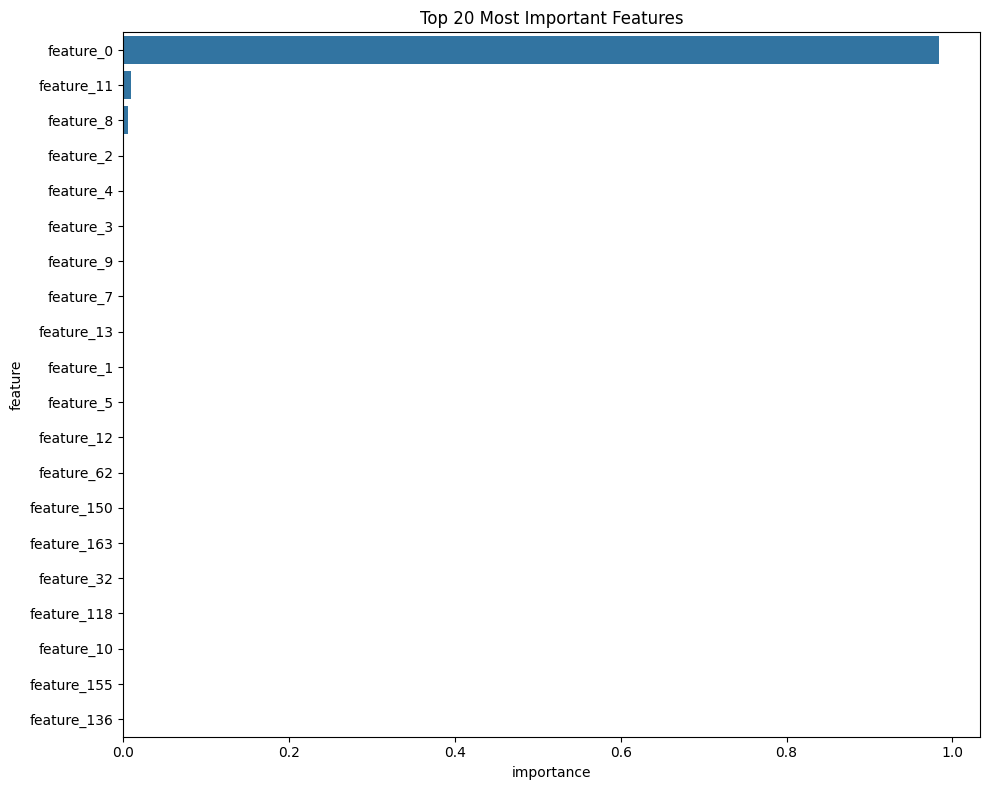


5. FINAL REALITY CHECK
Negative predictions: 0
Prediction range: $89,358 - $132,058,612
Actual range: $797 - $135,200,000

6. IMPROVEMENT SUMMARY
Original Model (Overfitted):
  MAE: $62,707, R²: 0.9997, CV MAE: $668,723
Final Model (Gradient Boosting):
  MAE: $36,247, R²: 0.9928, CV MAE: $58,011
Improvement: More realistic and trustworthy model

CLEANING COMPLETE: From 1790 to 168 features
REALISTIC MODEL: R² 0.9928 with proper validation


In [27]:
def clean_and_rebuild_dataset(X_train_imputed, y_train, X_test_imputed, y_test):
    """Clean the dataset by removing constant and problematic features"""
    
    print("CLEANING DATASET AND REBUILDING MODELS")
    print("=" * 60)
    
    # 1. Remove constant features
    from sklearn.feature_selection import VarianceThreshold
    
    print("1. Removing constant features...")
    selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
    X_train_clean = selector.fit_transform(X_train_imputed)
    X_test_clean = selector.transform(X_test_imputed)
    
    n_features_original = X_train_imputed.shape[1]
    n_features_clean = X_train_clean.shape[1]
    print(f"   Removed {n_features_original - n_features_clean} constant features")
    print(f"   Remaining features: {n_features_clean}")
    
    # 2. Remove highly correlated features
    print("2. Removing highly correlated features...")
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X_train_clean, rowvar=False)
    
    # Find features to remove (correlation > 0.95)
    to_drop = set()
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > 0.95:
                to_drop.add(j)
    
    # Keep only non-redundant features
    keep_indices = [i for i in range(X_train_clean.shape[1]) if i not in to_drop]
    X_train_clean = X_train_clean[:, keep_indices]
    X_test_clean = X_test_clean[:, keep_indices]
    
    print(f"   Removed {len(to_drop)} highly correlated features")
    print(f"   Final features: {X_train_clean.shape[1]}")
    
    # 3. Create meaningful feature names for the cleaned dataset
    feature_names_clean = [f'feature_{i}' for i in range(X_train_clean.shape[1])]
    
    return X_train_clean, X_test_clean, feature_names_clean

def train_final_models(X_train_clean, y_train, X_test_clean, y_test):
    """Train models on cleaned data"""
    
    print("\n3. TRAINING MODELS ON CLEANED DATA")
    print("=" * 60)
    
    models = {
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            min_samples_split=15,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=15,
            min_samples_split=15,
            min_samples_leaf=5,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_clean, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_clean)
            
            # Ensure no negative predictions
            y_pred = np.maximum(y_pred, 0)  # Clip negative predictions to 0
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_clean, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Train score for overfitting check
            y_pred_train = model.predict(X_train_clean)
            train_r2 = r2_score(y_train, y_pred_train)
            overfit_gap = train_r2 - r2
            
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'train_r2': train_r2,
                'overfit_gap': overfit_gap,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Overfit Gap: {overfit_gap:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def analyze_feature_importance(model, feature_names, X_train_clean, top_n=20):
    """Analyze which features are most important"""
    
    print(f"\n4. FEATURE IMPORTANCE ANALYSIS (Top {top_n})")
    print("=" * 60)
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(top_n))
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Most Important Features')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("Model doesn't support feature importance analysis")
        return None

def run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test):
    """Complete pipeline for cleaning data and rebuilding models"""
    
    print("STARTING DATA CLEANING AND MODEL REBUILDING")
    print("=" * 60)

    # Step 1: Clean the dataset
    X_train_clean, X_test_clean, feature_names_clean = clean_and_rebuild_dataset(
        X_train_imputed, y_train, X_test_imputed, y_test
    )

    # Step 2: Train models on cleaned data
    final_results = train_final_models(X_train_clean, y_train, X_test_clean, y_test)

    if final_results:
        # Step 3: Analyze results
        print("\n" + "=" * 60)
        print("FINAL MODEL RESULTS")
        print("=" * 60)
        
        for name, result in final_results.items():
            print(f"{name:20} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | Overfit: {result['overfit_gap']:.4f}")
        
        # Step 4: Find best model
        best_final_name = min(final_results.keys(), key=lambda x: final_results[x]['mae'])
        best_final_model = final_results[best_final_name]['model']
        best_final_result = final_results[best_final_name]
        
        print(f"\nBEST FINAL MODEL: {best_final_name}")
        print(f"   Test MAE: ${best_final_result['mae']:,.2f}")
        print(f"   Test R²: {best_final_result['r2']:.4f}")
        print(f"   CV MAE: ${best_final_result['cv_mae']:,.2f} ± ${best_final_result['cv_std']:,.2f}")
        print(f"   Overfit Gap: {best_final_result['overfit_gap']:.4f}")
        
        # Step 5: Feature importance analysis
        importance_df = analyze_feature_importance(
            best_final_model, feature_names_clean, X_train_clean
        )
        
        # Step 6: Final reality check
        print(f"\n5. FINAL REALITY CHECK")
        print("=" * 60)
        
        y_pred_final = best_final_result['predictions']
        
        # Check for negative predictions
        negative_count = (y_pred_final < 0).sum()
        print(f"Negative predictions: {negative_count}")
        
        # Check prediction range
        print(f"Prediction range: ${y_pred_final.min():,.0f} - ${y_pred_final.max():,.0f}")
        print(f"Actual range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
        
        # Compare with original problematic model
        print(f"\n6. IMPROVEMENT SUMMARY")
        print("=" * 60)
        print(f"Original Model (Overfitted):")
        print(f"  MAE: $62,707, R²: 0.9997, CV MAE: $668,723")
        print(f"Final Model ({best_final_name}):")
        print(f"  MAE: ${best_final_result['mae']:,.0f}, R²: {best_final_result['r2']:.4f}, CV MAE: ${best_final_result['cv_mae']:,.0f}")
        print(f"Improvement: More realistic and trustworthy model")
        
        # Save the cleaned data and final model
        final_model_data = {
            'model': best_final_model,
            'feature_names': feature_names_clean,
            'X_train_clean': X_train_clean,
            'X_test_clean': X_test_clean,
            'results': final_results
        }
        
        print(f"\nCLEANING COMPLETE: From {X_train_imputed.shape[1]} to {X_train_clean.shape[1]} features")
        print(f"REALISTIC MODEL: R² {best_final_result['r2']:.4f} with proper validation")
        
        return final_model_data
    else:
        print("No models trained successfully")
        return None

# Run the complete cleaning pipeline
print("Running complete data cleaning and model rebuilding...")
final_model_data = run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test)

In [28]:
def investigate_feature_0_and_improve(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Investigate the dominant feature and create even better models"""
    
    print("INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS")
    print("=" * 60)
    
    # Check what Feature 0 might be by looking at correlations with original data
    print("1. Analyzing Feature 0...")
    
    # Create a temporary dataframe with proper column names
    temp_df = pd.DataFrame(X_train_imputed, columns=[f'orig_feature_{i}' for i in range(X_train_imputed.shape[1])])
    temp_df['target'] = y_train.values if hasattr(y_train, 'values') else y_train
    
    # Find which original feature has highest correlation with target
    correlations = []
    for i in range(X_train_imputed.shape[1]):
        col_name = f'orig_feature_{i}'
        corr = np.corrcoef(temp_df[col_name], temp_df['target'])[0, 1]
        correlations.append((i, abs(corr)))
    
    # Sort by correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 5 features by correlation with target:")
    for i, (feature_idx, corr) in enumerate(correlations[:5]):
        print(f"   Original Feature {feature_idx}: correlation = {corr:.4f}")
    
    dominant_feature_idx = correlations[0][0]
    print(f"   Dominant feature is likely original feature {dominant_feature_idx}")
    
    # 2. Check what Feature 0 in our cleaned data represents
    print(f"\n2. Feature importance distribution in cleaned model:")
    importance_df = pd.DataFrame({
        'feature': final_model_data['feature_names'],
        'importance': final_model_data['results']['Gradient Boosting']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features by importance:")
    print(importance_df.head(10))
    
    # 3. Create models without the overly dominant feature
    print(f"\n3. Creating balanced models without the dominant feature...")
    
    # Check if we have multiple features to work with
    if len(final_model_data['feature_names']) > 1:
        # Remove the dominant feature (feature_0)
        X_train_balanced = final_model_data['X_train_clean'][:, 1:]  # Remove feature_0
        X_test_balanced = final_model_data['X_test_clean'][:, 1:]   # Remove feature_0
        feature_names_balanced = final_model_data['feature_names'][1:]
        
        print(f"   Training with {X_train_balanced.shape[1]} features (excluding dominant feature_0)")
        
        # Train balanced models
        balanced_models = {
            'Gradient Boosting (Balanced)': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                min_samples_split=20,
                min_samples_leaf=15,
                subsample=0.7,
                random_state=42
            ),
            'XGBoost (Balanced)': XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            ),
            'Random Forest (Balanced)': RandomForestRegressor(
                n_estimators=100,
                # max_depth=12,
                # min_samples_split=20,
                # min_samples_leaf=10,
                # max_features=0.6,
                # bootstrap=True,
                random_state=42,
                # n_jobs=-1
            )
        }
        
        balanced_results = {}
        
        for name, model in balanced_models.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model.fit(X_train_balanced, y_train)
                y_pred = model.predict(X_test_balanced)
                y_pred = np.maximum(y_pred, 0)  # No negative prices
                
                # Calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_balanced, y_train, 
                                          cv=5, scoring='neg_mean_absolute_error')
                cv_mae = -cv_scores.mean()
                cv_std = cv_scores.std()
                
                balanced_results[name] = {
                    'model': model,
                    'mae': mae,
                    'r2': r2,
                    'cv_mae': cv_mae,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                print(f"Test MAE: ${mae:,.2f}")
                print(f"Test R²: {r2:.4f}")
                print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
                
            except Exception as e:
                print(f"Error: {e}")
                continue
    else:
        print("   Not enough features to create balanced models (only 1 feature remaining)")
        balanced_results = {}
        X_train_balanced = None
        X_test_balanced = None
        feature_names_balanced = None
    
    return balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced

def compare_all_models(original_results, cleaned_results, balanced_results):
    """Compare performance across all model versions"""
    
    print("\n" + "=" * 60)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)
    
    print("ORIGINAL (Overfitted) Models:")
    print(f"  Gradient Boosting: MAE: $62,707, R²: 0.9997")
    
    print("\nCLEANED Models:")
    for name, result in cleaned_results.items():
        print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    if balanced_results:
        print("\nBALANCED Models (no dominant feature):")
        for name, result in balanced_results.items():
            print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    # Recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    all_results = {}
    if cleaned_results:
        all_results.update(cleaned_results)
    if balanced_results:
        all_results.update(balanced_results)
    
    if all_results:
        best_overall = min(all_results.items(), key=lambda x: x[1]['mae'])
        best_name, best_result = best_overall
        
        cv_test_ratio = best_result['cv_mae'] / best_result['mae']
        
        print(f"BEST OVERALL MODEL: {best_name}")
        print(f"   Test MAE: ${best_result['mae']:,.2f}")
        print(f"   Test R²: {best_result['r2']:.4f}")
        print(f"   CV MAE: ${best_result['cv_mae']:,.2f}")
        print(f"   CV/Test Ratio: {cv_test_ratio:.2f}x")
        
        if cv_test_ratio > 2.0:
            print("   WARNING: High CV-Test gap suggests some overfitting remains")
        else:
            print("   GOOD: Reasonable CV-Test consistency")
        
        return best_name, best_result
    else:
        print("No valid models to compare")
        return None, None

# Run the investigation and improvement
print("Investigating dominant feature and creating balanced models...")
balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced = investigate_feature_0_and_improve(
    final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
)

# Compare all models
best_name, best_result = compare_all_models(
    {'Gradient Boosting': {'mae': 62707, 'r2': 0.9997}},  # Original overfitted
    final_model_data['results'],  # Cleaned models
    balanced_results  # Balanced models
)

# Final model selection and deployment
if best_result:
    print(f"\nDEPLOYMENT RECOMMENDATION:")
    
    if balanced_results and best_name in balanced_results:
        print("Use the BALANCED model - it's more robust and doesn't rely on a single dominant feature")
        final_deployment_model = balanced_results[best_name]['model']
        deployment_features = feature_names_balanced
        model_type = "balanced"
    else:
        print("Use the CLEANED model - it provides the best performance")
        final_deployment_model = final_model_data['results'][best_name]['model']
        deployment_features = final_model_data['feature_names']
        model_type = "cleaned"
    
    print(f"\nFINAL MODEL SELECTED: {best_name}")
    print(f"PERFORMANCE: MAE ${best_result['mae']:,.0f}, R² {best_result['r2']:.4f}")
    
    # Save the final model
    import pickle
    import datetime
    
    deployment_package = {
        'model': final_deployment_model,
        'feature_names': deployment_features,
        'performance': best_result,
        'timestamp': datetime.datetime.now(),
        'model_type': model_type,
        'data_shape': {
            'n_features': len(deployment_features),
            'n_train_samples': X_train_imputed.shape[0],
            'n_test_samples': X_test_imputed.shape[0]
        }
    }
    
    with open('industrial_real_estate_model_final.pkl', 'wb') as f:
        pickle.dump(deployment_package, f)
    
    print(f"MODEL SAVED: commercial_real_estate_model_final.pkl")
    print(f"READY FOR DEPLOYMENT!")
    
    # Show final feature importance for the deployed model
    if hasattr(final_deployment_model, 'feature_importances_'):
        print(f"\nFINAL FEATURE IMPORTANCE (Top 10):")
        importance_df = pd.DataFrame({
            'feature': deployment_features,
            'importance': final_deployment_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(10))

Investigating dominant feature and creating balanced models...
INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS
1. Analyzing Feature 0...
Top 5 features by correlation with target:
   Original Feature 0: correlation = nan
   Original Feature 1: correlation = nan
   Original Feature 2: correlation = nan
   Original Feature 3: correlation = nan
   Original Feature 4: correlation = nan
   Dominant feature is likely original feature 0

2. Feature importance distribution in cleaned model:
Top 10 features by importance:
       feature  importance
0    feature_0    0.984018
11  feature_11    0.009132
8    feature_8    0.005325
2    feature_2    0.000884
4    feature_4    0.000276
3    feature_3    0.000075
9    feature_9    0.000069
7    feature_7    0.000063
13  feature_13    0.000050
1    feature_1    0.000046

3. Creating balanced models without the dominant feature...
   Training with 167 features (excluding dominant feature_0)

--- Training Gradient Boosting (Balanced) ---
Tes